# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
using Base.Threads
println("Usando ", nthreads(), " threads 😎")

Usando 1 threads 😎


In [2]:
import Pkg
Pkg.activate("../")
Pkg.instantiate()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`


In [3]:
import Pkg; Pkg.add(["Revise", "GLMakie"])

   Resolving package versions...
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Project.toml`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Manifest.toml`


In [4]:
using Revise
using CellBasedModels
using CUDA
using Distributions
using GLMakie
# using GeometryBasics
import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187


## Forces model

We already use the defined forces model that is implemented in CBMModels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [5]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :type=>Int,
        ),    #Local Interaction Parameters

    model = Dict(
            :n=>Int,
            :Ebb=>Float64,
            :Ebg=>Float64,
            :Egg=>Float64,
            :epsbb=>Float64,
            :epsbg=>Float64,
            :epsgg=>Float64,
            :etab=>Float64,
            :etag=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces(x,y,d,l,theta,etab,type, 
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],etag,type[i2], Ebb, Ebg, Egg)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            #Use the model provided in the documentation
            # Fijx, Fijy, Wij = CBMModels.attractiveForces(x,y,d,l,theta,etab,type, 
                                    # x[i2],y[i2],d[i2],l[i2],theta[i2],etag,type[i2], epsbb, epsbg, epsgg)

            
            
            # #Append the repulsive forces
            # fx += Fijx
            # fy += Fijy
            # W += Wij
            # #Keep track of preassure in the media
            # pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a community with two bacteries and check forces

In [6]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.n=30
com.Ebb=100. *m/(t^2*d)*1.E-3 #kPa
com.Ebg=100. *m/(t^2*d)*1.E-3 #kPa
com.Egg=100. *m/(t^2*d)*1.E-3 #kPa

com.epsbb=3.E8 *m*d/t^2 #Pa um^2
com.epsbg=28. *m*d/t^2 #Pa um^2
com.epsgg=18. *m*d/t^2 #Pa um^2

com.etab=500 *m/(t*d) #Pa h
com.etag=500 *m/(t*d) #Pa h


1.8000000000000003

In [7]:
com.Ebb, com.epsbb, com.etab

([1.296], [0.003887999999999999], [1.8000000000000003])

In [8]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    if i <= com.n[1]  # agentes del 0 al 4 (long rods)
        com.type[i] = 0
        com.l[i] = 3.0
        com.d[i] = 1.0
    else       # agentes del 5 al 9 (puntos o discos)
        com.type[i] = 1
        com.l[i] = 0
        com.d[i] = 0.8
    end
end

In [9]:
evolve!(com,steps=8000,saveEach=100,preallocateAgents=com.N)

In [10]:
function plotMixedAgents2D!(ax, x, y, d, l, angle, type, p; kargs...)
    for (xi, yi, li, di, ai, ti, pi) in zip(x, y, l, d, angle, type, p)


        if ti== 0  # rods
            colorval = pi
            colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
        else  # puntos
            colorval = RGBf(0, 1, 1)  # rojo puro
            meshscatter!(ax,
                [Point3f(xi, yi, 0.0)];  # ¡usar coordenadas 3D!
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],  # ¡tamaño real 3D!
                color = [colorval],
                kargs...
            )
        end

    end
    return
end


plotMixedAgents2D! (generic function with 1 method)

In [11]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

GLMakie.Screen(...)

In [12]:
using JSON

function log_community_state(parameters::OrderedDict, t::Int, path::String = "parameters_log.txt")
    # Convert keys to strings so JSON can serialize them
    string_keys = Dict(string(k) => v for (k, v) in parameters)
    # Build entry
    entry = Dict("t" => t, "parameters" => string_keys)
    # Save as a JSON line
    open(path, "a") do io
        println(io, JSON.json(entry))
    end
end


function load_parameters_log(path::String = "parameters_log.txt")
    log = Dict{Int, OrderedDict{Symbol, Any}}()
    for line in eachline(path)
        entry = JSON.parse(line)
        t = entry["t"]
        raw_params = entry["parameters"]
        params = OrderedDict(Symbol(k) => v for (k, v) in raw_params)
        log[t] = params
    end
    times = sort(collect(keys(log)))
    com_array = [log[t] for t in times]
    return com_array, times
end



load_parameters_log (generic function with 2 methods)

In [13]:
steps=8000
saveEach=100
N=100
loadToPlatform!(com,preallocateAgents=N)
open("parameters_log.txt", "w") do f
    # clear file at start
end


for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if  N - com.N[1] < 2*com.N[1]
            N = 4*com.N[1]
        end
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end


Step 100 N: 30
Step 200 N: 30
Step 300 N: 30
Step 400 N: 30
Step 500 N: 30
Step 600 N: 30
Step 700 N: 30
Step 800 N: 30
Step 900 N: 30
Step 1000 N: 30
Step 1100 N: 30
Step 1200 N: 30
Step 1300 N: 30
Step 1400 N: 30
Step 1500 N: 30
Step 1600 N: 30
Step 1700 N: 30
Step 1800 N: 30
Step 1900 N: 30
Step 2000 N: 30
Step 2100 N: 30
Step 2200 N: 30
Step 2300 N: 30
Step 2400 N: 30
Step 2500 N: 30
Step 2600 N: 30
Step 2700 N: 30
Step 2800 N: 30
Step 2900 N: 30
Step 3000 N: 30
Step 3100 N: 30
Step 3200 N: 30
Step 3300 N: 30
Step 3400 N: 30
Step 3500 N: 30
Step 3600 N: 30
Step 3700 N: 30
Step 3800 N: 30
Step 3900 N: 30
Step 4000 N: 30
Step 4100 N: 30
Step 4200 N: 30
Step 4300 N: 30
Step 4400 N: 30
Step 4500 N: 30
Step 4600 N: 30
Step 4700 N: 30
Step 4800 N: 30
Step 4900 N: 30
Step 5000 N: 30
Step 5100 N: 30
Step 5200 N: 30
Step 5300 N: 30
Step 5400 N: 30
Step 5500 N: 30
Step 5600 N: 30
Step 5700 N: 30
Step 5800 N: 30
Step 5900 N: 30
Step 6000 N: 30
Step 6100 N: 30
Step 6200 N: 30
Step 6300 N: 30
S

In [14]:
com_,times=load_parameters_log("parameters_log.txt")

(OrderedDict{Symbol, Any}[OrderedDict(:epsbb => Any[0.0038880000356584787], :W => Any[-1.4550537663637897e-8, 3.362934464234968e-8, -1.3180782021393611e-9, 5.956360027425944e-8, -5.004780617712257e-11, 1.3961704681264564e-8, -1.0643206849181297e-7, 2.65343960137443e-8, -7.839642535145686e-8, 1.4542860249378009e-8  …  0.0, 2.369600871077182e-8, 5.225904331496167e-8, 0.0, 4.5166572704147256e-8, 3.748114707491368e-8, 2.564267376214957e-8, 1.0167630293267393e-8, -6.189320611582616e-9, 0.0], :fx => Any[3.375513912828865e-8, 1.0591093513312444e-7, 2.9229459741486608e-8, 1.8549899039044249e-7, 5.4994613307712825e-9, 1.1864198512512303e-7, -5.0421245845200247e-8, 1.1079043105155506e-7, -2.3559600492717436e-7, 2.319199943201511e-8  …  0.0, 1.0417269891149772e-7, -4.7623555587961164e-7, 0.0, 1.0205845768496147e-7, 2.3755649181111949e-7, -2.3841796803480975e-7, 4.7693344384924785e-8, -1.112694825167182e-8, 0.0], :x => Any[-0.8708339929580688, -5.653445720672607, -0.5389334559440613, 6.23900938034

In [15]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com_)/4):length(com_);length(com_)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com_[j][:x],
    com_[j][:y],
    com_[j][:d],
    com_[j][:l],
    com_[j][:theta],
    com_[j][:type],
    com_[j][:pressure],
    colorrange = (0, maximum((p[:pressure][1]) for p in com_))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

GLMakie.Screen(...)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [16]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64,
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64,
                :σ=>Float64,
                :p_half=>Float64,
                :DMedium => Float64,
                :delta => Float64,
                :qrate => Float64, 
            ),
    
    medium = Dict(
        :mm => Float64        #Add a medium parameter
    ),

 
    agentODE = quote
        if type == 0
            dt(l) = l*growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
        end
        
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)/10000 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=0)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww,
                    type=0)
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing PGA with a saturating function
        pq = 1/(1+α*pressure)
        prelease = σ * mm / (p_half + mm)

        if CBMDistributions.uniform(0, 1) < prelease
            # PGA release!
            # You could mark it, count it, or log it here
            # @info "PGA released at step $(step) by agent ID $(id)"
            aux=CBMDistributions.rand_pm()
            @addAgent(
                    # x=((l+d)*(rand()-1/2)+aux*d/2)*cos(theta)+x,
                    # y=((l+d)*(rand()-1/2)-aux*d/2)*sin(theta)+y,
                    x=(CBMDistributions.uniform(-1,1)*(l+d)/2+aux*d/2)*cos(theta)+x,
                    y=(CBMDistributions.uniform(-1,1)*(l+d)/2-aux*d/2)*sin(theta)+y,
                    l=0,
                    d=0.5,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=1)

        end
        if CBMDistributions.uniform(0, 1) < prelease
            mm += qrate
        end

           

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(mm) = DMedium*(@∂2(1,mm)+@∂2(2,mm)) - delta# we only diffuse in x as the symmetry is in x
            # dt(mm) = DMedium*(@∂2(1,mm)+@∂2(2,mm))-delta*mm# we only diffuse in x as the symmetry is in x
       elseif @mediumBorder(1,-1) #x last
            mm = 0
        elseif @mediumBorder(1,1) #x fist??
            mm = 0 #Oscillatory behaviour
        elseif @mediumBorder(2,1) #y first
            mm = 0
        elseif @mediumBorder(2,-1) #y last
            mm = 0
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [17]:
com = Community(rods2dGrowth,
            N=1,
            dt=1.,
            simBox = [-100 100;-100 100.],
            NMedium=[100,100],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.n=30
com.Ebb=20. *m/(t^2*d)*1.E-3 #kPa
com.Ebg=10. *m/(t^2*d)*1.E-3 #kPa
com.Egg=5. *m/(t^2*d)*1.E-3 #kPa

# com.epsbb=5.E7 *m*d/t^2 #Pa um^2
# com.epsbg=18. *m*d/t^2 #Pa um^2
# com.epsgg=18. *m*d/t^2 #Pa um^2

com.etab=500 *m/(t*d) #Pa h
com.etag=500 *m/(t*d) #Pa h

com.DMedium = 1.E-3
com.delta = 1.E-4
com.qrate = 1.E-3 

com.growth = 0.5 * t
com.lMax = 3.     
com.σlTarget = .2 
com.α = 200
com.σ = 1E-3
com.type=0

com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.p_half=4.

com.x = 0
com.y = 0
com.theta = 0;

In [18]:
steps=10000
saveEach=1000
N=100 

loadToPlatform!(com,preallocateAgents=N)
open("parameters_log.txt", "w") do f
    # clear file at start
end

for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1])
                warning("More agents than preallocateAgents, stopping simulation.")
                break
        elseif  N - com.N[1] < 4*com.N[1]
                N = 4*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end

Step 1000 N: 2
Step 2000 N: 2
Step 3000 N: 2
Step 4000 N: 2
Step 5000 N: 2
Step 6000 N: 2
Step 7000 N: 2
Step 8000 N: 2
Step 9000 N: 4
Step 10000 N: 4


In [19]:
com_load,times=load_parameters_log("parameters_log.txt")


(OrderedDict{Symbol, Any}[OrderedDict(:epsbb => Any[0.0], :DMedium => Any[0.001], :W => Any[-4.7995701197864e-10, -4.7995701197864e-10], :fx => Any[-7.665776695243381e-5, 7.665776695243381e-5], :x => Any[-1.0604213050111513, 1.0604213050111513], :σlTarget => Any[0.2], :delta => Any[0.0001], :theta => Any[-7.163231740011162e-6, -7.163231740011162e-6], :qrate => Any[0.001], :epsbg => Any[0.0]…), OrderedDict(:epsbb => Any[0.0], :DMedium => Any[0.001], :W => Any[-6.350258912984854e-10, -6.350258912984854e-10], :fx => Any[-8.76713745295887e-5, 8.76713745295887e-5], :x => Any[-1.142461281097743, 1.142461281097743], :σlTarget => Any[0.2], :delta => Any[0.0001], :theta => Any[-7.716263165329908e-6, -7.716263165329908e-6], :qrate => Any[0.001], :epsbg => Any[0.0]…), OrderedDict(:epsbb => Any[0.0], :DMedium => Any[0.001], :W => Any[-8.559577001054118e-10, -8.559577001054118e-10], :fx => Any[-0.00010020389165616697, 0.00010020389165616697], :x => Any[-1.2362583808760714, 1.2362583808760714], :σlT

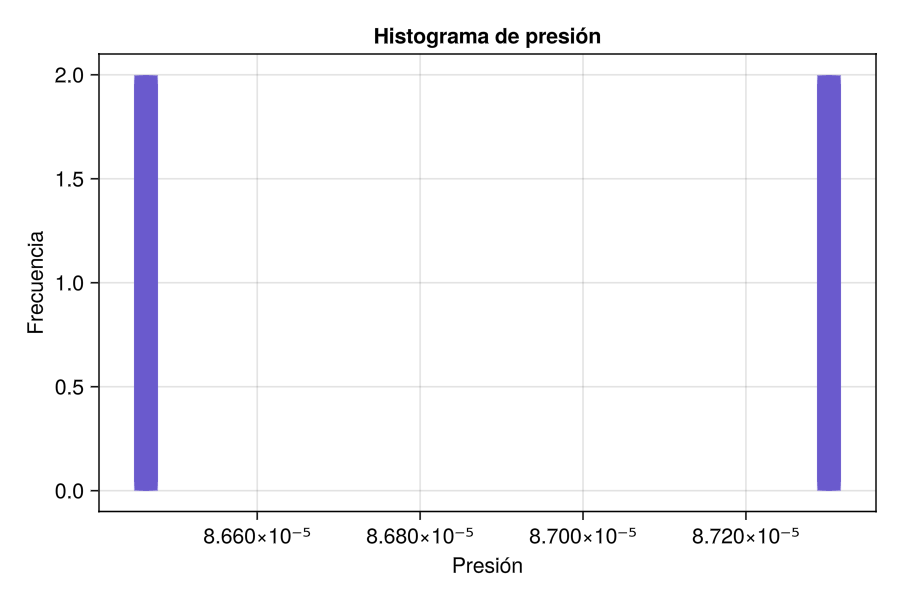

In [20]:
# Elegimos un frame, por ejemplo el último
p = com_load[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [21]:
# Colormap común y colorrange fijo
colormap = :viridis
colorrange = (0.0, maximum(com.mm))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                Float64.(hcat(com_load[j][:mm]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotMixedAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

LoadError: Invalid text boundingbox GeometryBasics.HyperRectangle{3, Float64}([109.0, NaN, 0.0], [7.783999919891357, 16.309999465942383, 0.0])

In [ ]:
# Colormap común y colorrange fijo
colormap = :viridis
colorrange = (0.0, maximum(com.mm))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                Float64.(hcat(com_load[j][:mm]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:pressure],
    # colorrange = (0, 0.03)
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

GLMakie.Screen(...)

In [ ]:
using GLMakie

# Configuración general
colormap = :viridis
colorrange = (0.0, maximum(com.mm))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



GLMakie.record(fig, "bacterias_video_pressure_qs_proves.mp4", 1:length(com_load); framerate = 15) do j
 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.mm)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.mm)[2])
    z = copy(hcat(com_load[j][:mm]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotMixedAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:type],
        com_load[j][:pressure],
        colorrange = (0, 0.03)
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_video_pressure_qs_proves.mp4"

In [ ]:


# Configuración general
colormap = :viridis
colorrange = (0.0, maximum(com.mm))

# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



GLMakie.record(fig, "bacterias_video_pressure_qs_2_proves.mp4", 1:length(com_load); framerate = 15) do j
 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.mm)[1])
    y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.mm)[2])
    z = copy(hcat(com_load[j][:mm]...))  # inicializa con primer frame

    hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    # plotMixedAgents2D!(
    #     ax,
    #     com_load[j][:x],
    #     com_load[j][:y],
    #     com_load[j][:d],
    #     com_load[j][:l],
    #     com_load[j][:theta],
    #     com_load[j][:type],
    #     com_load[j][:pressure],
    #     colorrange = (0, 0.03)
    # )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_video_pressure_qs_2_proves.mp4"